In [1]:
import sys
import os
import uproot
import glob
import pandas as pd
import numpy as np
import ROOT
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.18/00


In [ ]:
def plot_mva(df, column, bins, logscale=False, ax=None, title=None, ls='dashed', alpha=0.5, sample='',cat="Matchlabel",Wt="Wt"):
    histtype="bar" 
    if sample is 'test':
        histtype="step"      
    if ax is None:
        ax = plt.gca()
    for name, group in df.groupby(cat):
        if name == 0:
            label="background"
        else:
            label="signal"
        group[column].hist(bins=bins, histtype=histtype, alpha=0.7,
                           label=label+' '+sample, ax=ax, density=True, ls=ls, weights =group[Wt],linewidth=2)
    #ax.set_ylabel("density")
    ax.set_xlabel(column)
    ax.legend(fontsize=10)
    ax.set_title(title)
    if logscale:
        ax.set_yscale("log", nonposy='clip')

In [39]:
def plot_roc_curve(df, score_column, tpr_threshold=0, ax=None, color=None, linestyle='-', label=None,cat="Matchlabel",Wt="Wt"):
    from sklearn import metrics
    if ax is None: ax = plt.gca()
    if label is None: label = score_column
    fpr, tpr, thresholds = metrics.roc_curve(df[cat], df[score_column],sample_weight=df[Wt])
    mask = tpr > tpr_threshold
    fpr, tpr = fpr[mask], tpr[mask]
    auc=metrics.auc(fpr, tpr)
    label=label+' auc='+str(round(auc*100,1))+'%'
    ax.legend()
    ax.plot(tpr, fpr, label=label, color=color, linestyle=linestyle,linewidth=4)
    return auc


In [2]:
TrainConfig=sys.argv[1]
TrainConfig="TrainConfig"
print("Importing settings from "+ TrainConfig)
exec("from "+TrainConfig+" import *")

Importing settings from TrainConfig


In [3]:

print("Making output directory")
os.system("mkdir -p " + OutputDirName)
os.system("cp TrainConfig.py ./"+ OutputDirName+"/")
os.system("cp Trainer.py ./"+ OutputDirName+"/")

Making output directory


0

In [4]:
cat='EleType'
weight="NewWt"
label=["Background","Signal"]

In [5]:
#Works in uproot3
print("Making data frames")
Sigdf=pd.DataFrame()
Bkgdf=pd.DataFrame()

for SigFile,SigXsecWt,SigCut in zip(SigFiles,SigXsecWts,SigCuts):
    if Debug==True:
        Sigdfi = uproot.open(SigFile).get(Tree).pandas.df().query(SigCut+' & '+CommonCut).iloc[::10]
    else:
        Sigdfi = uproot.open(SigFile).get(Tree).pandas.df().query(SigCut+' & '+CommonCut)
    Sigdfi['xsecwt']=SigXsecWt
    Sigdf=pd.concat([Sigdf,Sigdfi],ignore_index=True, sort=False)
for BkgFile,BkgXsecWt,BkgCut in zip(BkgFiles,BkgXsecWts,BkgCuts):
    if Debug==True:
        Bkgdfi = uproot.open(BkgFile).get(Tree).pandas.df().query(BkgCut+' & '+CommonCut).iloc[::10]
    else:
        Bkgdfi = uproot.open(BkgFile).get(Tree).pandas.df().query(BkgCut+' & '+CommonCut)
    Bkgdfi['xsecwt']=BkgXsecWt
    Bkgdf=pd.concat([Bkgdf,Bkgdfi],ignore_index=True, sort=False)

Making data frames


In [6]:
Sigdf[cat]=1
Bkgdf[cat]=0

Sigdf["Type"]="Signal"
Bkgdf["Type"]="Background"

#Reweighing
Sigdf[weight]=1
Bkgdf[weight]=1

df_final=pd.concat([Sigdf,Bkgdf],ignore_index=True, sort=False)
from sklearn.model_selection import train_test_split
TrainIndices, TestIndices = train_test_split(df_final.index.values.tolist(), test_size=testsize, random_state=RandomState, shuffle=True)

df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0

df_final["NewWt"]=1

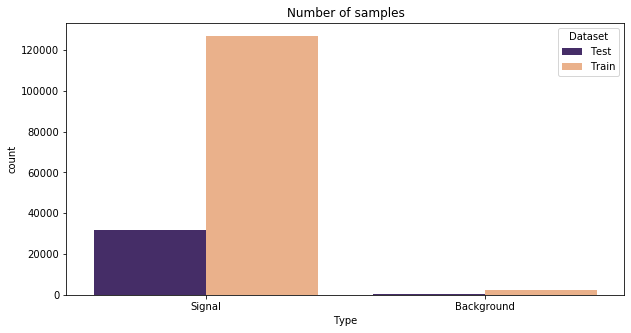

In [7]:
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x="Type", data=df_final, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B"])
axes.set_title("Number of samples")
#axes.set_yscale("log")
plt.savefig(OutputDirName+"/TotalStat_TrainANDTest.png")
    

Making feature plots


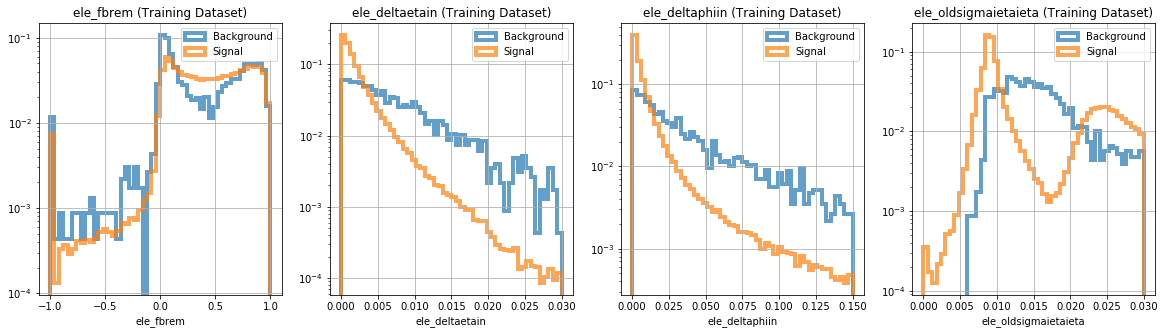

In [8]:
fig, axes = plt.subplots(1, len(features), figsize=(len(features)*5, 5))
print("Making feature plots")
for m in range(len(features)):
    for i,group_df in df_final[df_final['Dataset'] == "Train"].groupby(cat):
        group_df[features[m-1]].hist(histtype='step', bins=feature_bins[m-1], alpha=0.7,label=label[i], ax=axes[m-1], density=False, ls='-', weights =group_df[weight]/group_df[weight].sum(),linewidth=4)
        #df_new = pd.concat([group_df, df_new],ignore_index=True, sort=False)                                                                                            
    axes[m-1].legend(loc='upper right')
    axes[m-1].set_xlabel(features[m-1])
    axes[m-1].set_yscale("log")
    axes[m-1].set_title(features[m-1]+" (Training Dataset)")
plt.savefig(OutputDirName+"/featureplots_Training.png")

Making feature plots


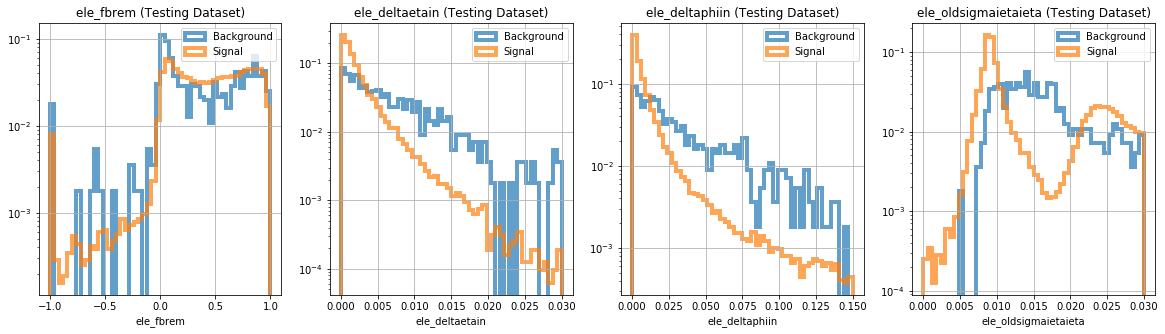

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, len(features), figsize=(len(features)*5, 5))
print("Making feature plots")
for m in range(len(features)):
    for i,group_df in df_final[df_final['Dataset'] == "Test"].groupby(cat):
        group_df[features[m-1]].hist(histtype='step', bins=feature_bins[m-1], alpha=0.7,label=label[i], ax=axes[m-1], density=False, ls='-', weights =group_df[weight]/group_df[weight].sum(),linewidth=4)
        #df_new = pd.concat([group_df, df_new],ignore_index=True, sort=False)                                                                                            
    axes[m-1].legend(loc='upper right')
    axes[m-1].set_xlabel(features[m-1])
    axes[m-1].set_yscale("log")
    axes[m-1].set_title(features[m-1]+" (Testing Dataset)")
plt.savefig(OutputDirName+"/featureplots_Testing.png")

In [10]:
X_train = df_final.loc[TrainIndices,features]
Y_train = df_final.loc[TrainIndices,cat]
Wt_train = df_final.loc[TrainIndices,weight]
    
X_test = df_final.loc[TestIndices,features]
Y_test = df_final.loc[TestIndices,cat]
Wt_test = df_final.loc[TestIndices,weight]

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
Wt_train = np.asarray(Wt_train)
    
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
Wt_test = np.asarray(Wt_test)

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Expected accuracy of XGB model = 98.0%
Expected accuracy of XGB model = 98.34487352262342%


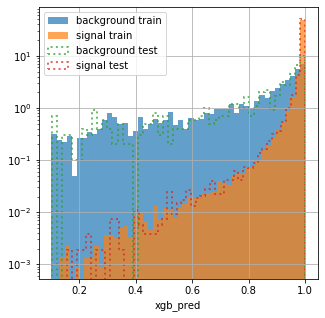

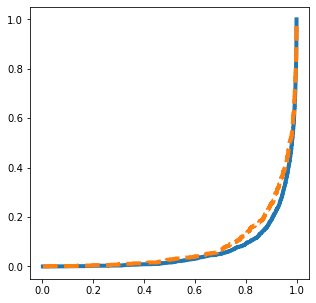

In [40]:
if 'XGB' in MVAs:
    import xgboost as xgb
    from sklearn.model_selection import cross_val_score, GridSearchCV
    parameters = {'learning_rate':[0.1, 0.01, 0.001]}
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=RandomState)
    #xgb_model.set_config(verbosity=2)
    cv = GridSearchCV(xgb_model, parameters,scoring = 'accuracy')
    search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=1)

    print("Expected accuracy of XGB model = "+str((np.round(np.average(search.best_score_),2))*100)+'%')
    print("Expected accuracy of XGB model = "+str((np.average(search.best_score_))*100)+'%')

    search.best_params_

    df_final.loc[TrainIndices,"xgb_pred"]=cv.predict_proba(X_train)[:,1]
    df_final.loc[TestIndices,"xgb_pred"]=cv.predict_proba(X_test)[:,1]

    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    plot_mva(df_final.query('TrainDataset==1'),"xgb_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=True)
    plot_mva(df_final.query('TrainDataset==0'),"xgb_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=True)
    plt.savefig(OutputDirName+"/XGBMVA.png")
    
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    plot_roc_curve(df_final.query('TrainDataset==1'),"xgb_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label='Training',cat=cat,Wt=weight)
    plot_roc_curve(df_final.query('TrainDataset==0'),"xgb_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label='Testing',cat=cat,Wt=weight)
    plt.savefig(OutputDirName+"/XGBROC.png")

In [42]:
if 'DNN' in MVAs:
    print("Please note, DNN is not implemented Yet! Coming soon!")

Please note, DNN is not implemented Yet! Coming soon


In [43]:
os.system("convert "+OutputDirName+"/*.png "+OutputDirName+"/mydoc.pdf")

0

convert: /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/libtiff.so.5: no version information available (required by /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/libMagickCore-7.Q16HDRI.so.6)
convert: UnableToOpenConfigureFile `magic.xml' @ warning/configure.c/GetConfigureOptions/714.
